# Project Goals:
- Create documented files to clean and prepare H4 Nucleosome Occupancy dataset for processing by modeling via a multiple classification ML and ANN algorithms.
- Use K-mers to create datasets from the raw genetic sequence data
- Pass K-mer datasets to a Bag of Words CountVectorizer
- Pass dataframes with new vectorized features and nucleotide counts to classification models.
- Find a model that hopefully outpreforms both the modal baseline and the best preforming model from the origin website

# Executive Summary:
> ## Key Takeaways:
> - I achieved a ~84.4% accuracy on test data using a Multinomial Naive Bayes test.
> - I did beat baseline but did not beat the best model from www.jaist.ac
>     - My best model lost by roughly 4 points

> ## Reccomendations:
> I reccomend that the model used by www.jaist.ac be used in lieu of my own models. Additionally, the hexamer dataset seemed to be more indicative of positive or negative labels than the codon dataset. If pursuing the ANN models further I reccomend using a model with at least one hidden layer as it outpreformed the single layer model slightly with the codon dataset and significantly improved with the hexamer dataset.

## Imports

In [1]:
import acquire as ac
import preprocessing as pr 
import explore as ex
import model as md

import pandas as pd
import numpy as np
import re
import unicodedata
import nltk

from tensorflow import keras
import tensorflow as tf
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import os
from wordcloud import WordCloud

from Bio.Seq import Seq
from Bio import SeqIO

import matplotlib.pyplot as plt

import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#Importing different classifier from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, cross_validate

import warnings
warnings.simplefilter('ignore')

# Acquire
#### With the help of my acquire.py script:
- Pull H4 nucleosome occupancy sequence data from http://www.jaist.ac.jp/~tran/nucleosome/ten_dataset/dataset02.txt in the form of a .txt file
- Convert this .txt file into a format useable by pandas for passing to dataframe
- Preform pre-preperation summary of data

In [2]:
# Acquire raw data on histone occupancy
h4 = ac.get_H4_data()
h4.head(3)

,id,sequence,label
0,iTELL-Chr1_61\n,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,0
1,iYAL067W-A_3174\n,TTTCTAAGTGGGATTTTTCTTAATCCTTGGATTCTTAAAAGGTTAT...,1
2,iYAL067W-A_4141\n,AAAGCCATTAAGGTCCAGATAACCAAGGGACAATAAACCTATGCTT...,1


In [3]:
# Checking for nulls and shape of data
h4.isnull().sum(), h4.shape

(id          0
 sequence    0
 label       0
 dtype: int64,
 (14601, 3))

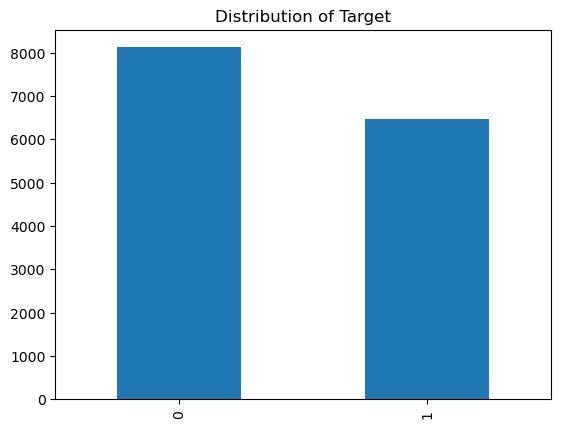

In [4]:
# Distribution of label (Target var))
h4.label.value_counts().sort_index().plot.bar()
plt.title('Distribution of Target')
plt.show()

# Preparation
- Clean IDs and create useful features such as nucleotide distributions
- Check lengths of sequences for any unusual lengths (!= 500)
- Vectorize sequences into hexamers and codons via Bag of Words CountVectorizer
- Train, Validate, Test split:
    - Split X data for codons and hexamers
    - Split y data for labels

### Cleaning data and checking for discrepancies

In [5]:
# Cleaning id strings with \n appending
h4.id = h4.id.apply(lambda x: x.replace('\n', '')) # deleting /n appending each id
h4.head()

,id,sequence,label
0,iTELL-Chr1_61,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,0
1,iYAL067W-A_3174,TTTCTAAGTGGGATTTTTCTTAATCCTTGGATTCTTAAAAGGTTAT...,1
2,iYAL067W-A_4141,AAAGCCATTAAGGTCCAGATAACCAAGGGACAATAAACCTATGCTT...,1
3,iYAL067W-A_6428,CCATCATTTTACTTCCACATAAGTTCTAATGTTACGTAGTTCAATT...,0
4,iYAL067W-A_6786,AATTATATTTCCATCAGCTCAATACCGCAGTACTTTGAAACCTGAT...,0


In [6]:
h4.shape

(14601, 3)

In [7]:
# Checking sequence lengths for abnormal (!= 500) lengths
unexpected = pr.check_len(h4)
unexpected

Unexpected sequence length at index: 0, length 310.
Unexpected sequence length at index: 263, length 449.


,id,sequence,label
0,iTELL-Chr1_61,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,0
263,iTELR-Chr1_230009,TTATATTTGTTTAAATTGGATTTGTTTACATTAGATTTGTTTACAT...,0


In [8]:
# Dropping unexpected rows
h4 = h4.drop(unexpected.index)

In [9]:
pr.check_len(h4)

,id,sequence,label


In [10]:
h4 = h4.reset_index(drop = True)
h4.head()

,id,sequence,label
0,iYAL067W-A_3174,TTTCTAAGTGGGATTTTTCTTAATCCTTGGATTCTTAAAAGGTTAT...,1
1,iYAL067W-A_4141,AAAGCCATTAAGGTCCAGATAACCAAGGGACAATAAACCTATGCTT...,1
2,iYAL067W-A_6428,CCATCATTTTACTTCCACATAAGTTCTAATGTTACGTAGTTCAATT...,0
3,iYAL067W-A_6786,AATTATATTTCCATCAGCTCAATACCGCAGTACTTTGAAACCTGAT...,0
4,iYAL067W-A_7060,AACAATAGTGGGTATGAGTAAAGATATATAGATCGATATTTTGAAT...,0


### Cleaning takeaways:
- IDs had appending /n char
- Two entries had a sequence length != 500
    - The two entries were both chromosome sequences, and both were label 0

### Pre-exploration Feature Creation:

In [11]:
# Creates features for the nucleotide count of each sequence
h4 = pr.nucleotide_count(h4)
h4.head()

,id,sequence,label,adenine,cytosine,guanine,thymine
0,iYAL067W-A_3174,TTTCTAAGTGGGATTTTTCTTAATCCTTGGATTCTTAAAAGGTTAT...,1,168,94,76,162
1,iYAL067W-A_4141,AAAGCCATTAAGGTCCAGATAACCAAGGGACAATAAACCTATGCTT...,1,166,89,85,160
2,iYAL067W-A_6428,CCATCATTTTACTTCCACATAAGTTCTAATGTTACGTAGTTCAATT...,0,160,92,68,180
3,iYAL067W-A_6786,AATTATATTTCCATCAGCTCAATACCGCAGTACTTTGAAACCTGAT...,0,185,70,75,170
4,iYAL067W-A_7060,AACAATAGTGGGTATGAGTAAAGATATATAGATCGATATTTTGAAT...,0,168,61,85,186


## NLP Bag of Words CountVectorizer

In [12]:
# Create overlapping hexamers(6 bases) and codons(3 bases) of each sequence for processing
h4['hexamers'] = h4.apply(lambda x: pr.getKmers(x['sequence']), axis=1)
h4['codons'] = h4.apply(lambda x: pr.getKmers(x['sequence'], k = 3), axis=1)

In [13]:
h4.head(1)

,id,sequence,label,adenine,cytosine,guanine,thymine,hexamers,codons
0,iYAL067W-A_3174,TTTCTAAGTGGGATTTTTCTTAATCCTTGGATTCTTAAAAGGTTAT...,1,168,94,76,162,"[tttcta, ttctaa, tctaag, ctaagt, taagtg, aagtg...","[ttt, ttc, tct, cta, taa, aag, agt, gtg, tgg, ..."


In [14]:
# Creating dataframes of hexamers and codons for processing by Bag of Words CountVectorizer
hexamers = h4[['hexamers', 'label']]
codons = h4[['codons', 'label']]

In [15]:
# Checking new codon df
codons.head(3)

,codons,label
0,"[ttt, ttc, tct, cta, taa, aag, agt, gtg, tgg, ...",1
1,"[aaa, aag, agc, gcc, cca, cat, att, tta, taa, ...",1
2,"[cca, cat, atc, tca, cat, att, ttt, ttt, tta, ...",0


In [16]:
# Checking new hexamer df
hexamers.head(3)

,hexamers,label
0,"[tttcta, ttctaa, tctaag, ctaagt, taagtg, aagtg...",1
1,"[aaagcc, aagcca, agccat, gccatt, ccatta, catta...",1
2,"[ccatca, catcat, atcatt, tcattt, catttt, atttt...",0


In [17]:
# Joining each list of hexamers into a 'sentence' for BoW processing
hexamer_vectors = list(hexamers['hexamers'].values)
for i in range(len(hexamer_vectors)):
    hexamer_vectors[i] = ' '.join(hexamer_vectors[i])

In [18]:
codon_vectors = list(codons['codons'].values)
for i in range(len(codon_vectors)):
    codon_vectors[i] = ' '.join(codon_vectors[i])

In [19]:
hexamer_vectors[0]

'tttcta ttctaa tctaag ctaagt taagtg aagtgg agtggg gtggga tgggat gggatt ggattt gatttt attttt tttttc ttttct tttctt ttctta tcttaa cttaat ttaatc taatcc aatcct atcctt tccttg ccttgg cttgga ttggat tggatt ggattc gattct attctt ttctta tcttaa cttaaa ttaaaa taaaag aaaagg aaaggt aaggtt aggtta ggttat gttatt ttatta tattaa attaaa ttaaag taaagt aaagtt aagttc agttcc gttccg ttccgc tccgca ccgcac cgcaca gcacaa cacaaa acaaag caaaga aaagaa aagaac agaacg gaacgc aacgct acgctt cgcttg gcttgg cttgga ttggaa tggaaa ggaaat gaaatc aaatcg aatcgc atcgca tcgcat cgcatt gcattc cattca attcat ttcatc tcatca catcaa atcaaa tcaaag caaaga aaagaa aagaac agaaca gaacaa aacaac acaact caactc aactct actctt ctcttc tcttcg cttcgt ttcgtt tcgttt cgtttt gttttc ttttcc tttcca ttccaa tccaaa ccaaac caaaca aaacaa aacaat acaatc caatct aatctt atcttc tcttcc cttccc ttcccg tcccga cccgaa ccgaaa cgaaaa gaaaaa aaaaag aaaagt aaagta aagtag agtagc gtagcc tagccg agccgt gccgtt ccgttc cgttca gttcat ttcatt tcattt catttc atttcc tttccc ttccct tccctt cccttc ccttc

In [20]:
codon_vectors[0]

'ttt ttc tct cta taa aag agt gtg tgg ggg gga gat att ttt ttt ttt ttc tct ctt tta taa aat atc tcc cct ctt ttg tgg gga gat att ttc tct ctt tta taa aaa aaa aag agg ggt gtt tta tat att tta taa aaa aag agt gtt ttc tcc ccg cgc gca cac aca caa aaa aag aga gaa aac acg cgc gct ctt ttg tgg gga gaa aaa aat atc tcg cgc gca cat att ttc tca cat atc tca caa aaa aag aga gaa aac aca caa aac act ctc tct ctt ttc tcg cgt gtt ttt ttt ttc tcc cca caa aaa aac aca caa aat atc tct ctt ttc tcc ccc ccg cga gaa aaa aaa aaa aag agt gta tag agc gcc ccg cgt gtt ttc tca cat att ttt ttc tcc ccc cct ctt ttc tcc ccg cga gat att ttt ttc tca cat att ttc tcc cct cta tag aga gac act ctg tgc gcc cca caa aaa aat att ttt ttt ttt ttc tct ctt ttg tgc gct ctc tca cat att ttt tta tat ata taa aat atg tga gat att ttg tga gat ata taa aag aga gaa aat att ttg tgt gta tat att ttt ttg tgt gtg tgt gtc tcc ccc cca cat att ttc tct ctc tcg cgt gta tag aga gat ata taa aaa aaa aat att ttc tct ctt ttg tgg gga gat atg tgt gtt tta taa aaa aaa aaa

In [21]:
# Using Bag of Words count vectorizer for hexamers
cv = CountVectorizer(ngram_range=(1,1))
X_hex = cv.fit_transform(hexamer_vectors).toarray()
unique_hexamers = cv.get_feature_names()

In [22]:
# Using Bag of Words count vectorizer for codons
X_cod = cv.fit_transform(codon_vectors).toarray()
unique_codons = cv.get_feature_names()

In [23]:
# Checking data
X_hex[0], X_cod[0]

(array([2, 0, 2, ..., 3, 0, 1]),
 array([36, 10, 16, 14,  7,  3,  3,  3, 13,  6,  4,  7, 11,  8,  6, 21, 12,
         1,  4, 15,  7,  6,  4,  6,  3,  3,  1,  3,  2,  6,  1, 18, 14,  2,
         3, 11,  5,  3,  0,  5,  7,  0,  5,  3,  6,  2,  3,  7, 14,  3,  7,
         6, 13, 12,  3, 13,  7,  4,  5,  5, 11, 25, 11, 23]))

In [24]:
# Creating DFs from array of arrays for hexamers and codons
X_hex = pd.DataFrame(X_hex, columns = unique_hexamers)
X_cod = pd.DataFrame(X_cod, columns = unique_codons)

In [25]:
# Adding ACGT counts to hexamers and codons
X_hex['adenine'] = h4.adenine
X_hex['cytosine'] = h4.cytosine
X_hex['guanine'] = h4.guanine
X_hex['thymine'] = h4.thymine

X_cod['adenine'] = h4.adenine
X_cod['cytosine'] = h4.cytosine
X_cod['guanine'] = h4.guanine
X_cod['thymine'] = h4.thymine

In [26]:
X_hex.head()

,aaaaaa,aaaaac,aaaaag,aaaaat,aaaaca,aaaacc,aaaacg,aaaact,aaaaga,aaaagc,...,ttttgg,ttttgt,ttttta,tttttc,tttttg,tttttt,adenine,cytosine,guanine,thymine
0,2,0,2,2,0,0,0,0,0,0,...,0,0,0,3,0,1,168,94,76,162
1,1,0,1,2,0,0,0,0,1,0,...,1,1,0,0,1,2,166,89,85,160
2,1,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,160,92,68,180
3,15,0,1,2,1,0,0,0,1,0,...,2,0,2,0,0,5,185,70,75,170
4,0,0,2,1,0,0,0,1,1,0,...,1,2,2,2,0,7,168,61,85,186


In [27]:
X_cod.head()

,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tgg,tgt,tta,ttc,ttg,ttt,adenine,cytosine,guanine,thymine
0,36,10,16,14,7,3,3,3,13,6,...,5,5,11,25,11,23,168,94,76,162
1,16,11,16,19,12,5,3,8,6,9,...,4,12,13,11,10,23,166,89,85,160
2,20,7,10,20,4,8,3,7,8,4,...,4,3,26,15,11,26,160,92,68,180
3,41,12,9,19,8,6,1,9,5,3,...,3,3,16,8,14,31,185,70,75,170
4,24,9,10,17,5,3,5,8,9,3,...,4,9,19,11,9,41,168,61,85,186


### Train, Validate, Test split:

In [28]:
y_data = h4.label.values
y_data[:5]

array([1, 1, 0, 0, 0])

In [29]:
# Splitting the data into X/y splits and exploratory splits
Hex_train, Hex_validate, Hex_test, y_train, y_validate, y_test = pr.tvt_split(X_hex, y_data)

# Splitting codons into train/test
Cod_train, Cod_validate, Cod_test = pr.tvt_split(X_cod)

# Splitting h4 for exploration
explore_train, explore_validate, explore_test = pr.tvt_split(h4)


In [30]:
# Checking hexamer subset shapes
Hex_train.shape, Hex_validate.shape, Hex_test.shape

((8175, 4100), (3504, 4100), (2920, 4100))

In [31]:
# Checking codon subset shapes
Cod_train.shape, Cod_validate.shape, Cod_test.shape 

((8175, 68), (3504, 68), (2920, 68))

In [32]:
# Sanity check
y_train[:10] == explore_train.label.values[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [33]:
Hex_train.head()

,aaaaaa,aaaaac,aaaaag,aaaaat,aaaaca,aaaacc,aaaacg,aaaact,aaaaga,aaaagc,...,ttttgg,ttttgt,ttttta,tttttc,tttttg,tttttt,adenine,cytosine,guanine,thymine
14085,1,1,0,1,0,0,0,2,0,0,...,1,0,0,0,1,3,164,89,104,143
13466,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,157,99,103,141
8961,5,1,0,3,0,0,0,1,0,0,...,0,0,0,0,0,0,160,88,88,164
2542,0,2,0,3,3,1,0,1,1,1,...,0,0,0,0,0,0,189,102,90,119
8877,0,0,1,0,1,0,0,0,1,0,...,0,0,1,0,1,0,156,85,108,151


In [34]:
Cod_train.head()

,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tgg,tgt,tta,ttc,ttg,ttt,adenine,cytosine,guanine,thymine
14085,22,9,11,15,8,2,4,10,12,6,...,8,5,7,7,12,18,164,89,104,143
13466,19,8,11,18,5,7,5,8,9,5,...,6,8,14,5,4,11,157,99,103,141
8961,28,5,9,17,8,5,5,6,10,6,...,6,10,12,13,16,18,160,88,88,164
2542,34,12,14,19,14,5,3,6,12,7,...,7,1,6,10,7,9,189,102,90,119
8877,17,7,14,13,7,6,1,7,13,6,...,10,7,10,9,14,16,156,85,108,151


### Scaling Hexamer and Codon Dataframes:

In [35]:
# Using MinMaxScaler to transform train, validate, test splits for hexamers
scaler = MinMaxScaler()
Hex_train_scaled = scaler.fit_transform(Hex_train)
Hex_validate_scaled = scaler.fit_transform(Hex_validate)
Hex_test_scaled = scaler.fit_transform(Hex_test)

# Setting scaled hexamer df indices of dataframes to the train, validate, test indicies
Hex_train_scaled = pd.DataFrame(Hex_train_scaled, columns = Hex_train.columns, index = Hex_train.index)
Hex_validate_scaled = pd.DataFrame(Hex_validate_scaled, columns = Hex_validate.columns, index = Hex_validate.index)
Hex_test_scaled = pd.DataFrame(Hex_test_scaled, columns = Hex_test.columns, index = Hex_test.index)

In [36]:
Hex_train_scaled.head()

,aaaaaa,aaaaac,aaaaag,aaaaat,aaaaca,aaaacc,aaaacg,aaaact,aaaaga,aaaagc,...,ttttgg,ttttgt,ttttta,tttttc,tttttg,tttttt,adenine,cytosine,guanine,thymine
14085,0.023810,0.166667,0.000,0.142857,0.000000,0.00,0.0,0.50,0.000,0.00,...,0.25,0.0,0.000000,0.0,0.111111,0.075,0.572222,0.322275,0.440476,0.414508
13466,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.0,0.00,0.000,0.25,...,0.00,0.0,0.000000,0.0,0.000000,0.000,0.533333,0.369668,0.434524,0.404145
8961,0.119048,0.166667,0.000,0.428571,0.000000,0.00,0.0,0.25,0.000,0.00,...,0.00,0.0,0.000000,0.0,0.000000,0.000,0.550000,0.317536,0.345238,0.523316
2542,0.000000,0.333333,0.000,0.428571,0.428571,0.25,0.0,0.25,0.125,0.25,...,0.00,0.0,0.000000,0.0,0.000000,0.000,0.711111,0.383886,0.357143,0.290155
8877,0.000000,0.000000,0.125,0.000000,0.142857,0.00,0.0,0.00,0.125,0.00,...,0.00,0.0,0.166667,0.0,0.111111,0.000,0.527778,0.303318,0.464286,0.455959


In [37]:
# Using MinMaxScaler to transform train, validate, test splits for hexamers
scaler = MinMaxScaler()
Cod_train_scaled = scaler.fit_transform(Cod_train)
Cod_validate_scaled = scaler.fit_transform(Cod_validate)
Cod_test_scaled = scaler.fit_transform(Cod_test)

# Setting scaled hexamer df indices of dataframes to the train, validate, test indicies
Cod_train_scaled = pd.DataFrame(Cod_train_scaled, columns = Cod_train.columns, index = Cod_train.index)
Cod_validate_scaled = pd.DataFrame(Cod_validate_scaled, columns = Cod_validate.columns, index = Cod_validate.index)
Cod_test_scaled = pd.DataFrame(Cod_test_scaled, columns = Cod_test.columns, index = Cod_test.index)

In [38]:
Cod_train_scaled.head()

,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tgg,tgt,tta,ttc,ttg,ttt,adenine,cytosine,guanine,thymine
14085,0.250000,0.257143,0.22,0.333333,0.173913,0.042553,0.210526,0.357143,0.315789,0.260870,...,0.242424,0.098039,0.142857,0.118644,0.196721,0.204545,0.572222,0.322275,0.440476,0.414508
13466,0.215909,0.228571,0.22,0.404762,0.108696,0.148936,0.263158,0.285714,0.236842,0.217391,...,0.181818,0.156863,0.285714,0.084746,0.065574,0.125000,0.533333,0.369668,0.434524,0.404145
8961,0.318182,0.142857,0.18,0.380952,0.173913,0.106383,0.263158,0.214286,0.263158,0.260870,...,0.181818,0.196078,0.244898,0.220339,0.262295,0.204545,0.550000,0.317536,0.345238,0.523316
2542,0.386364,0.342857,0.28,0.428571,0.304348,0.106383,0.157895,0.214286,0.315789,0.304348,...,0.212121,0.019608,0.122449,0.169492,0.114754,0.102273,0.711111,0.383886,0.357143,0.290155
8877,0.193182,0.200000,0.28,0.285714,0.152174,0.127660,0.052632,0.250000,0.342105,0.260870,...,0.303030,0.137255,0.204082,0.152542,0.229508,0.181818,0.527778,0.303318,0.464286,0.455959


# Exploration

In [39]:
# Taking a look at the explore data
explore_train.head(2)

,id,sequence,label,adenine,cytosine,guanine,thymine,hexamers,codons
14085,YPL026C_SKS1_501751,CATATAATATGAACTGCCAACGCACACATTTGGAGCTAGATATTTA...,1,164,89,104,143,"[catata, atataa, tataat, ataata, taatat, aatat...","[cat, ata, tat, ata, taa, aat, ata, tat, atg, ..."
13466,iYOR375C_1044573,AATCACAACCTATCTCTAGCCGCAAGATATATCTGTGTGAGAGGGG...,0,157,99,103,141,"[aatcac, atcaca, tcacaa, cacaac, acaacc, caacc...","[aat, atc, tca, cac, aca, caa, aac, acc, cct, ..."


In [40]:
# Checking percentage of labels in explore_train
ex.show_counts_and_ratios(explore_train, 'label')

,n,percent
0,4576,0.559755
1,3599,0.440245


In [41]:
X_hex.head()

,aaaaaa,aaaaac,aaaaag,aaaaat,aaaaca,aaaacc,aaaacg,aaaact,aaaaga,aaaagc,...,ttttgg,ttttgt,ttttta,tttttc,tttttg,tttttt,adenine,cytosine,guanine,thymine
0,2,0,2,2,0,0,0,0,0,0,...,0,0,0,3,0,1,168,94,76,162
1,1,0,1,2,0,0,0,0,1,0,...,1,1,0,0,1,2,166,89,85,160
2,1,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,160,92,68,180
3,15,0,1,2,1,0,0,0,1,0,...,2,0,2,0,0,5,185,70,75,170
4,0,0,2,1,0,0,0,1,1,0,...,1,2,2,2,0,7,168,61,85,186


In [42]:
# Checking the number of occurrances of each vector
Hex_vector_count = ex.vector_counts(X_hex.drop(columns = ['adenine', 'cytosine', 'guanine', 'thymine']))
Hex_vector_count.head(10)

,Vector,Count
4095,tttttt,27175
0,aaaaaa,26237
3,aaaaat,12010
1023,attttt,11913
4093,tttttc,11071
2048,gaaaaa,11060
128,aagaaa,10827
4063,tttctt,10629
32,aaagaa,10035
512,agaaaa,9914


In [43]:
# Checking the number of occurrances of each vector
Cod_vector_count = ex.vector_counts(X_cod.drop(columns = ['adenine', 'cytosine', 'guanine', 'thymine']))
Cod_vector_count.head(10)

,Vector,Count
63,ttt,308472
0,aaa,306545
3,aat,212453
15,att,212037
12,ata,185429
51,tat,184597
32,gaa,173249
61,ttc,171966
48,taa,167218
60,tta,166686


# Modeling

In [44]:
# Baseline based on most common label
baseline = 0
for label in y_train:
    if label == 0:
        baseline += 1

base_acc = baseline / len(y_train)
print(f'{round(base_acc * 100, 2)}%')

55.98%


### Model baselines:
> #### Based on Most Common Label:
> - ~55.6%

> #### Based on best preforming model http://www.jaist.ac.jp/~tran/nucleosome:
![](JAIST_predictions.png)
> - Best model for H4 dataset used K-Mer lengths of 4,5
> - 88.09% 
> - Correlation coefficient = (0.76)

## Hexamer Basic Classifier Models:
- Exclusively Hexamer dataset
- Basic models
- Artificial Neural Network (ANN) models

In [45]:
# Names of models to be used in classifier_models
names = ['K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'AddaBoost', 
         'Gaussian N-Bayes', 'Multinomial N-Bayes']

# List of the classifiers to be used in modeling
classifiers = [
    KNeighborsClassifier(n_neighbors = 3),
    DecisionTreeClassifier(max_depth = 5),
    RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1 ),
    AdaBoostClassifier(),
    GaussianNB(),
    MultinomialNB()
    ]

In [46]:
hex_train_metrics_df = md.classifier_models(Hex_train_scaled, y_train, names, classifiers)
hex_train_metrics_df

K Nearest Neighbors: Accuracy: 0.6200607206878286, Coeff: None
Decision Tree: Accuracy: 0.7553556305045892, Coeff: None
Random Forest: Accuracy: 0.5614678006781324, Coeff: None
AddaBoost: Accuracy: 0.7975493262068574, Coeff: None
Gaussian N-Bayes: Accuracy: 0.8321674502398603, Coeff: None
Multinomial N-Bayes: Accuracy: 0.8459895616678587, Coeff: None


,Model,Accuracy
5,Multinomial N-Bayes,0.845990
4,Gaussian N-Bayes,0.832167
3,AddaBoost,0.797549
1,Decision Tree,0.755356
0,K Nearest Neighbors,0.620061
2,Random Forest,0.561468


In [47]:
# Evaluate on out-of-sample validate data
hex_val_metrics_df = md.classifier_models(Hex_validate_scaled, y_validate, names, classifiers)
hex_val_metrics_df

K Nearest Neighbors: Accuracy: 0.5770492470492471, Coeff: None
Decision Tree: Accuracy: 0.7442922262922264, Coeff: None
Random Forest: Accuracy: 0.5650590150590152, Coeff: None
AddaBoost: Accuracy: 0.7765641025641026, Coeff: None
Gaussian N-Bayes: Accuracy: 0.8193365893365894, Coeff: None
Multinomial N-Bayes: Accuracy: 0.8418876678876679, Coeff: None


,Model,Accuracy
5,Multinomial N-Bayes,0.841888
4,Gaussian N-Bayes,0.819337
3,AddaBoost,0.776564
1,Decision Tree,0.744292
0,K Nearest Neighbors,0.577049
2,Random Forest,0.565059


## Codon Basic Classifier Models:
- Exclusively Codon dataset
- Basic models
- Artificial Neural Network (ANN) models

In [48]:
# Evaluate on train
cod_train_metrics_df = md.classifier_models(Cod_train_scaled, y_train, names, classifiers)
cod_train_metrics_df

K Nearest Neighbors: Accuracy: 0.7905800636235497, Coeff: None
Decision Tree: Accuracy: 0.747519998324121, Coeff: None
Random Forest: Accuracy: 0.7190180845301404, Coeff: None
AddaBoost: Accuracy: 0.8073396019188814, Coeff: None
Gaussian N-Bayes: Accuracy: 0.7926572558079682, Coeff: None
Multinomial N-Bayes: Accuracy: 0.6785309424126074, Coeff: None


,Model,Accuracy
3,AddaBoost,0.807340
4,Gaussian N-Bayes,0.792657
0,K Nearest Neighbors,0.790580
1,Decision Tree,0.747520
2,Random Forest,0.719018
5,Multinomial N-Bayes,0.678531


In [49]:
# Evaluate on out-of-sample validate data
cod_val_metrics_df = md.classifier_models(Cod_validate_scaled, y_validate, names, classifiers)
cod_val_metrics_df

K Nearest Neighbors: Accuracy: 0.7668433048433049, Coeff: None
Decision Tree: Accuracy: 0.7237370777370777, Coeff: None
Random Forest: Accuracy: 0.7034831094831094, Coeff: None
AddaBoost: Accuracy: 0.8065095645095646, Coeff: None
Gaussian N-Bayes: Accuracy: 0.801949531949532, Coeff: None
Multinomial N-Bayes: Accuracy: 0.6795002035002036, Coeff: None


,Model,Accuracy
3,AddaBoost,0.806510
4,Gaussian N-Bayes,0.801950
0,K Nearest Neighbors,0.766843
1,Decision Tree,0.723737
2,Random Forest,0.703483
5,Multinomial N-Bayes,0.679500


## Hexamer Vector ANN
#### Hex ANN Learning Classification Model 1: Basic Model

In [50]:
# Converting df into list of arrays containing CountVectorized scaled values
X_train = Hex_train_scaled.values
X_validate = Hex_validate.values
X_test = Hex_test_scaled.values

In [51]:
# Converting y_train/test to categorical matrices
y_train_ = keras.utils.to_categorical(y_train, num_classes = 2)
y_validate_ = keras.utils.to_categorical(y_validate, num_classes = 2)
y_test_ = keras.utils.to_categorical(y_test, num_classes = 2)

In [52]:
# Sanity checking
len(X_train[0]) == len(Hex_train_scaled.columns), len(X_train[0]), len(X_train)

(True, 4100, 8175)

In [53]:
# Sanity checking
y_train_[1], explore_train.label.values[1]

(array([1., 0.], dtype=float32), 0)

In [54]:
# Make the basic ANN model with no hidden layers
model0 = keras.Sequential([
    keras.layers.Dense(2, input_dim = 4100, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation = 'sigmoid')
])

In [55]:
# Compile the model using categrical_crossentropy
model0.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [56]:
# Fitting the model
train_scores = model0.fit(X_train, y_train_, epochs = 100)

Epoch 1/100
256/256 [==============================] - 1s 1ms/step - loss: 0.5464 - accuracy: 0.8048
Epoch 2/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4587 - accuracy: 0.8758
Epoch 3/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4502 - accuracy: 0.8807
Epoch 4/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4486 - accuracy: 0.8828
Epoch 5/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4482 - accuracy: 0.8853
Epoch 6/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4475 - accuracy: 0.8870
Epoch 7/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4482 - accuracy: 0.8840
Epoch 8/100
256/256 [==============================] - 0s 2ms/step - loss: 0.4482 - accuracy: 0.8860: 0s - loss: 0.4458 - accuracy: 
Epoch 9/100
256/256 [==============================] - 1s 2ms/step - loss: 0.4482 - accuracy: 0.8860
Epoch 10/100
256/256 [==============================] - 0s 

256/256 [==============================] - 0s 2ms/step - loss: 0.4495 - accuracy: 0.8839
Epoch 81/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4487 - accuracy: 0.8856
Epoch 82/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4492 - accuracy: 0.8827
Epoch 83/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4484 - accuracy: 0.8854
Epoch 84/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4481 - accuracy: 0.8853
Epoch 85/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4491 - accuracy: 0.8826
Epoch 86/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4485 - accuracy: 0.8853
Epoch 87/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.8860
Epoch 88/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4477 - accuracy: 0.8876
Epoch 89/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4487 - accuracy: 

In [57]:
# Appending train metrics df with model score
hex_train_metrics_df = hex_train_metrics_df.append({'Model': 'ANN 1', 'Accuracy': train_scores.history['accuracy'][-1]}, ignore_index = True)

In [58]:
val_scores = model0.evaluate(X_validate, y_validate_)

110/110 [==============================] - 0s 1ms/step - loss: 15.3313 - accuracy: 0.5602


In [59]:
# Appending validate metrics df with model score
hex_val_metrics_df = hex_val_metrics_df.append({'Model': 'ANN 1', 'Accuracy': val_scores[1]}, ignore_index = True)

#### Hex ANN Learning Classification Model 2: 1 Hidden Layer

In [60]:
# Make the ANN model with a hidden layer
model1 = keras.Sequential([
    keras.layers.Dense(2919, input_dim = 4100, activation = 'relu'),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(2, activation = 'sigmoid')
])

In [61]:
# Compile the model using categrical_crossentropy
model1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [62]:
# Fitting the model
train_scores = model1.fit(X_train, y_train_, epochs = 5)

Epoch 1/5
256/256 [==============================] - 11s 43ms/step - loss: 0.3979 - accuracy: 0.8296
Epoch 2/5
256/256 [==============================] - 11s 42ms/step - loss: 0.1986 - accuracy: 0.9228
Epoch 3/5
256/256 [==============================] - 12s 46ms/step - loss: 0.0584 - accuracy: 0.9806
Epoch 4/5
256/256 [==============================] - 12s 47ms/step - loss: 0.0228 - accuracy: 0.9929
Epoch 5/5
256/256 [==============================] - 11s 43ms/step - loss: 0.0104 - accuracy: 0.9969


In [63]:
# Appending train metrics df with model score
hex_train_metrics_df = hex_train_metrics_df.append({'Model': 'ANN 2', 'Accuracy': train_scores.history['accuracy'][-1]}, ignore_index = True)

In [64]:
val_scores = model1.evaluate(X_validate, y_validate_)

110/110 [==============================] - 2s 15ms/step - loss: 3.1464 - accuracy: 0.8191


In [65]:
# Appending validate metrics df with model score
hex_val_metrics_df = hex_val_metrics_df.append({'Model': 'ANN 2', 'Accuracy': val_scores[1]}, ignore_index = True)

### Codon Vector ANN:
#### Codon ANN Learning Classification Model 1: Basic Model

In [66]:
# Converting df into list of arrays containing CountVectorized scaled values
X_train = Cod_train_scaled.values
X_validate = Cod_validate.values
X_test = Cod_test_scaled.values

In [67]:
# Sanity checking
len(X_train[0]) == len(Cod_train_scaled.columns), len(X_train[0]), len(X_train)

(True, 68, 8175)

In [68]:
# Make the basic ANN model with no hidden layers
model0 = keras.Sequential([
    keras.layers.Dense(2, input_dim = 68, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation = 'sigmoid')
])

In [69]:
# Compile the model using categrical_crossentropy
model0.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [70]:
# Fitting the model
train_scores = model0.fit(X_train, y_train_, epochs = 25)

Epoch 1/25
256/256 [==============================] - 0s 777us/step - loss: 0.6861 - accuracy: 0.6275
Epoch 2/25
256/256 [==============================] - 0s 749us/step - loss: 0.6328 - accuracy: 0.7187
Epoch 3/25
256/256 [==============================] - 0s 754us/step - loss: 0.6061 - accuracy: 0.7640
Epoch 4/25
256/256 [==============================] - 0s 773us/step - loss: 0.5919 - accuracy: 0.7829
Epoch 5/25
256/256 [==============================] - 0s 752us/step - loss: 0.5848 - accuracy: 0.7938
Epoch 6/25
256/256 [==============================] - 0s 776us/step - loss: 0.5809 - accuracy: 0.7969
Epoch 7/25
256/256 [==============================] - 0s 1ms/step - loss: 0.5787 - accuracy: 0.8045
Epoch 8/25
256/256 [==============================] - 0s 1ms/step - loss: 0.5779 - accuracy: 0.8050
Epoch 9/25
256/256 [==============================] - 0s 801us/step - loss: 0.5771 - accuracy: 0.8069
Epoch 10/25
256/256 [==============================] - 0s 1ms/step - loss: 0.5769 - ac

In [71]:
# Appending train metrics df with model score
cod_train_metrics_df = cod_train_metrics_df.append({'Model': 'ANN 1', 'Accuracy': train_scores.history['accuracy'][-1]}, ignore_index = True)

In [72]:
val_scores = model0.evaluate(X_validate, y_validate_)

110/110 [==============================] - 0s 1ms/step - loss: 40.0140 - accuracy: 0.5608


In [73]:
# Appending validate metrics df with model score
cod_val_metrics_df = cod_val_metrics_df.append({'Model': 'ANN 1', 'Accuracy': val_scores[1]}, ignore_index = True)

#### Codon ANN Learning Classification Model 2: 1 Hidden Layer

In [74]:
# Make the ANN model with a hidden layer
model1 = keras.Sequential([
    keras.layers.Dense(60, input_dim = 68, activation = 'relu'),
    keras.layers.Dense(30, activation = 'relu'),
    keras.layers.Dense(2, activation = 'sigmoid')
])

In [75]:
# Compile the model using categrical_crossentropy
model1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [76]:
# Fitting the model
train_scores = model1.fit(X_train, y_train_, epochs = 5)

Epoch 1/5
256/256 [==============================] - 1s 1ms/step - loss: 0.5124 - accuracy: 0.7644
Epoch 2/5
256/256 [==============================] - 0s 1ms/step - loss: 0.3976 - accuracy: 0.8296
Epoch 3/5
256/256 [==============================] - 0s 1ms/step - loss: 0.3847 - accuracy: 0.8415
Epoch 4/5
256/256 [==============================] - 0s 2ms/step - loss: 0.3747 - accuracy: 0.8415
Epoch 5/5
256/256 [==============================] - 0s 1ms/step - loss: 0.3695 - accuracy: 0.8431


In [77]:
# Appending train metrics df with model score
cod_train_metrics_df = hex_train_metrics_df.append({'Model': 'ANN 2', 'Accuracy': train_scores.history['accuracy'][-1]}, ignore_index = True)

In [78]:
val_scores = model1.evaluate(X_validate, y_validate_)

110/110 [==============================] - 0s 2ms/step - loss: 87.5675 - accuracy: 0.5634


In [79]:
# Appending validate metrics df with model score
cod_val_metrics_df = cod_val_metrics_df.append({'Model': 'ANN 2', 'Accuracy': val_scores[1]}, ignore_index = True)

## Out-of-sample (Validate) Metrics:

In [80]:
hex_val_metrics_df

,Model,Accuracy
0,Multinomial N-Bayes,0.841888
1,Gaussian N-Bayes,0.819337
2,AddaBoost,0.776564
3,Decision Tree,0.744292
4,K Nearest Neighbors,0.577049
5,Random Forest,0.565059
6,ANN 1,0.560217
7,ANN 2,0.819064


In [81]:
cod_val_metrics_df

,Model,Accuracy
0,AddaBoost,0.806510
1,Gaussian N-Bayes,0.801950
2,K Nearest Neighbors,0.766843
3,Decision Tree,0.723737
4,Random Forest,0.703483
5,Multinomial N-Bayes,0.679500
6,ANN 1,0.560788
7,ANN 2,0.563356


### Pre-test takeaways:
- Multinomial Naive Bayes on the Hexamer data preformed the best of my models
    - Will use this model to evaluate on test
- All of the ANN models were considerably overfit
    - ANN 2 Preformed best of the ANN models on both Codon and Hexamer vector datasets

## Out-of-sample (Test) Evaluation:

In [83]:
# Evaluate Multinomial Naive Bayes on Test Data
test_metric_df = md.classifier_models(Hex_test_scaled, y_test, ['Multinomial N-Bayes'], [MultinomialNB()])

Multinomial N-Bayes: Accuracy: 0.8438356164383561, Coeff: None


In [84]:
test_metric_df

,Model,Accuracy
0,Multinomial N-Bayes,0.843836


# Conclusion:
> ## Modeling:
> - Best preforming model outpreformed baseline by almost 30 points on test data
> - Best model didnt beat preformance of http://www.jaist.ac.jp/~tran/nucleosome:
>     - My model lost by ~4 points

> ## Key Takeaways:
> - Overall, my ANN models seemed to rank in the middle/end of my models overall.
> - I achieved a ~84.4% accuracy on test data using a Multinomial Naive Bayes test.

> ## Reccomendations:
> - I reccomend that the model used by www.jaist.ac be used in lieu of my own models. Additionally, the hexamer dataset seemed to be more indicative of positive or negative labels than the codon dataset. If pursuing the ANN models further I reccomend using a model with at least one hidden layer as it outpreformed the single layer model slightly with the codon dataset and significantly improved with the hexamer dataset.

> ## Future Iterations:
> For any future iterations I would like to further develop my ANN models to try and minimize the prevalent overfitting issue present in my ANN models. I would like to try different vector lengths instead of 3 and 6 and would try to maximize model preformance with further tinkering with model hyperparameters. 